In [42]:
import numpy as np 
import pandas as pd
import re
import os
import pickle
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import warnings #filter and surpress warnings
warnings.filterwarnings('ignore')

In [43]:
mobiles = pd.read_csv('C:\\Users\\sandu\\OneDrive\\Desktop\\Mobile-Recommendation-System\\data\\mobile-data.csv')

In [44]:
mobiles.head()

,name,ratings,price,imgURL,corpus
0,"REDMI Note 12 Pro 5G (Onyx Black, 128 GB)",4.2,23999,https://rukminim2.flixcart.com/image/312/312/x...,Storage128 GBRAM6 SystemAndroid 12Processor T...
1,"OPPO F11 Pro (Aurora Green, 128 GB)",4.5,"₹20,999",https://rukminim2.flixcart.com/image/312/312/k...,Storage128 GBRAM6 GBExpandable Storage256GB S...
2,"REDMI Note 11 (Starburst White, 64 GB)",4.2,13149,https://rukminim2.flixcart.com/image/312/312/x...,Storage64 GBRAM4 SystemAndroid 11Processor Sp...
3,"OnePlus Nord CE 5G (Blue Void, 256 GB)",4.1,21999,https://rukminim2.flixcart.com/image/312/312/x...,Storage256 GBRAM12 SystemAndroid Q 11Processo...
4,"APPLE iPhone 13 mini (Blue, 128 GB)",4.6,3537,https://rukminim2.flixcart.com/image/312/312/k...,Storage128 SystemiOS 15Processor TypeA15 Bion...


In [45]:
mobiles.shape

(2546, 5)

In [46]:
mobiles.isnull().sum()

name        0
ratings     0
price       0
imgURL      0
corpus     12
dtype: int64

In [47]:
mobiles_clean=mobiles.dropna()

In [48]:
mobiles_clean.isnull().sum()

name       0
ratings    0
price      0
imgURL     0
corpus     0
dtype: int64

In [49]:
mobiles_clean.shape

(2534, 5)

In [50]:
mobiles_clean.loc[:,'corpus'] = mobiles_clean['corpus'].str.lower()

In [51]:
def extract_storage(corpus):
    match = re.search(r'storage(\d+)', corpus)
    if match:
        return int(match.group(1))
    return None

In [52]:
mobiles_clean.loc[:, 'storage'] = mobiles_clean['corpus'].apply(extract_storage)

In [53]:
mobiles_clean.head()

,name,ratings,price,imgURL,corpus,storage
0,"REDMI Note 12 Pro 5G (Onyx Black, 128 GB)",4.2,23999,https://rukminim2.flixcart.com/image/312/312/x...,storage128 gbram6 systemandroid 12processor t...,128.0
1,"OPPO F11 Pro (Aurora Green, 128 GB)",4.5,"₹20,999",https://rukminim2.flixcart.com/image/312/312/k...,storage128 gbram6 gbexpandable storage256gb s...,128.0
2,"REDMI Note 11 (Starburst White, 64 GB)",4.2,13149,https://rukminim2.flixcart.com/image/312/312/x...,storage64 gbram4 systemandroid 11processor sp...,64.0
3,"OnePlus Nord CE 5G (Blue Void, 256 GB)",4.1,21999,https://rukminim2.flixcart.com/image/312/312/x...,storage256 gbram12 systemandroid q 11processo...,256.0
4,"APPLE iPhone 13 mini (Blue, 128 GB)",4.6,3537,https://rukminim2.flixcart.com/image/312/312/k...,storage128 systemios 15processor typea15 bion...,128.0


In [54]:
def extract_ram(corpus):
    match = re.search(r'ram(\d+)', corpus)
    if match:
        return int(match.group(1))
    return None

In [55]:
mobiles_clean.loc[:, 'ram'] = mobiles_clean['corpus'].apply(extract_ram)

In [56]:
def extract_system(corpus):
    match = re.search(r'system(.*?)processor', corpus)
    if match:
        return match.group(1).strip()
    return None

In [57]:
mobiles_clean.loc[:, 'system'] = mobiles_clean['corpus'].apply(extract_system)

In [58]:
def extract_processor(corpus):
    match = re.search(r'processor (.*?) ', corpus)
    if match:
        return match.group(1).strip()
    return None

In [59]:
mobiles_clean.loc[:, 'processor'] = mobiles_clean['corpus'].apply(extract_processor)

In [60]:
mobiles_clean.head()

,name,ratings,price,imgURL,corpus,storage,ram,system,processor
0,"REDMI Note 12 Pro 5G (Onyx Black, 128 GB)",4.2,23999,https://rukminim2.flixcart.com/image/312/312/x...,storage128 gbram6 systemandroid 12processor t...,128.0,6.0,android 12,typemediatek
1,"OPPO F11 Pro (Aurora Green, 128 GB)",4.5,"₹20,999",https://rukminim2.flixcart.com/image/312/312/k...,storage128 gbram6 gbexpandable storage256gb s...,128.0,6.0,android pie 9.0,typemediatek
2,"REDMI Note 11 (Starburst White, 64 GB)",4.2,13149,https://rukminim2.flixcart.com/image/312/312/x...,storage64 gbram4 systemandroid 11processor sp...,64.0,4.0,android 11,speed2.4
3,"OnePlus Nord CE 5G (Blue Void, 256 GB)",4.1,21999,https://rukminim2.flixcart.com/image/312/312/x...,storage256 gbram12 systemandroid q 11processo...,256.0,12.0,android q 11,typequalcomm
4,"APPLE iPhone 13 mini (Blue, 128 GB)",4.6,3537,https://rukminim2.flixcart.com/image/312/312/k...,storage128 systemios 15processor typea15 bion...,128.0,NaN,ios 15,typea15


In [61]:
unique_systems = mobiles_clean['system'].unique()
unique_processors = mobiles_clean['processor'].unique()

In [62]:
unique_systems

array(['android 12', 'android pie 9.0', 'android 11', 'android q 11',
       'ios 15', 'ios 9', 'android 13', 'android pie 9',
       'android nougat 7', 'android 10', 'ios 16', None,
       'android q android q 12.5', 'android oreo 8.1',
       'android marshmallow 6.0.1', 'android oreo 8.1.0',
       'android 13 (go edition)', 'android android 12', 'android q 10',
       'ios 14.2', 'android pie android v9.0 (pie)', 'android andriod 11',
       'android android 10',
       'android hios 8.6 based on android 12-go edition',
       'android nougat 7.1', 'ios 14', 'android android 13', 'ios 12',
       'android 12 go', 'ios 7', 'android nougat 7.1.2',
       'android oreo v11', 'android android 13 oxygenos',
       'android android 13.0', 'android android v12.0',
       'android android 11', 'android pie 10', 'android oreo 8.0', 'q 10',
       'android q android 10', 'android q 12', 'ios 13',
       'android android 11 go', 'android 10 (go edition)',
       'android oxygen oxygenos base

In [63]:
unique_processors

array(['typemediatek', 'speed2.4', 'typequalcomm', 'typea15', 'typea9',
       None, 'speed2', 'typemtk', 'speed3.19', 'typedimensity',
       'typeunisoc', 'speed2.3', 'typea12', 'typea16', 'speed0.1',
       'typeexynos', 'typehelio', 'speed2.84', 'typemt6763tprocessor',
       'speed1.8', 'typea14', 'speed2.2', 'typea13', 'speed2.9', 'typea6',
       'speed3.05', 'typeapple', 'typesnapdragon', 'typequalcomm®',
       'typea11', 'speed2.99', 'typea10', 'speed3.2', 'speed208',
       'typemeditek', 'typea8', 'typesamsung', 'typeg37processor',
       'speed1.6', 'typeocta', 'type2nd-gen', 'typet612processor',
       'typeocta-coreprocessor', 'speed1.2', 'typespreadtrum', 'typesec',
       'typemtk6739', 'typesdm710processor', 'speed3', 'typena',
       'speed2.05', 'speed2.42', 'speed2.8', 'type1.6', 'type2.0',
       'type7nm', 'speed2.73', 'speed90', 'typemediateckprocessor',
       'speed900', 'speed120', 'speed2.7', 'speed1.3', 'speed1600',
       'typeeolprocessor', 'typenaprocess

In [64]:
def clean_system(system):
    if pd.isnull(system):
        return None
    if 'android' in system:
        return 'Android'
    if 'ios' in system:
        return 'iOS'
    if 'tizen' in system:
        return 'Tizen'
    return system

In [65]:
mobiles_clean.loc[:,'system'] = mobiles_clean['system'].apply(clean_system)

In [66]:
unique_systems_clean = mobiles_clean['system'].unique()

In [67]:
unique_systems_clean

array(['Android', 'iOS', None, 'q 10', 'series 30 feature phone', '1',
       'series 30', 'Tizen'], dtype=object)

In [68]:
def clean_processor(processor):
    """Clean the processor values."""
    if pd.isnull(processor):
        return None
    if 'mediatek' in processor:
        return 'MediaTek'
    if 'qualcomm' in processor:
        return 'Qualcomm'
    if 'apple' in processor:
        return 'Apple'
    return 'Other'

In [69]:
mobiles_clean.loc[:,'processor'] = mobiles_clean['processor'].apply(clean_processor)

In [70]:
unique_processors_clean = mobiles_clean['processor'].unique()

In [71]:
unique_processors_clean

array(['MediaTek', 'Other', 'Qualcomm', None, 'Apple'], dtype=object)

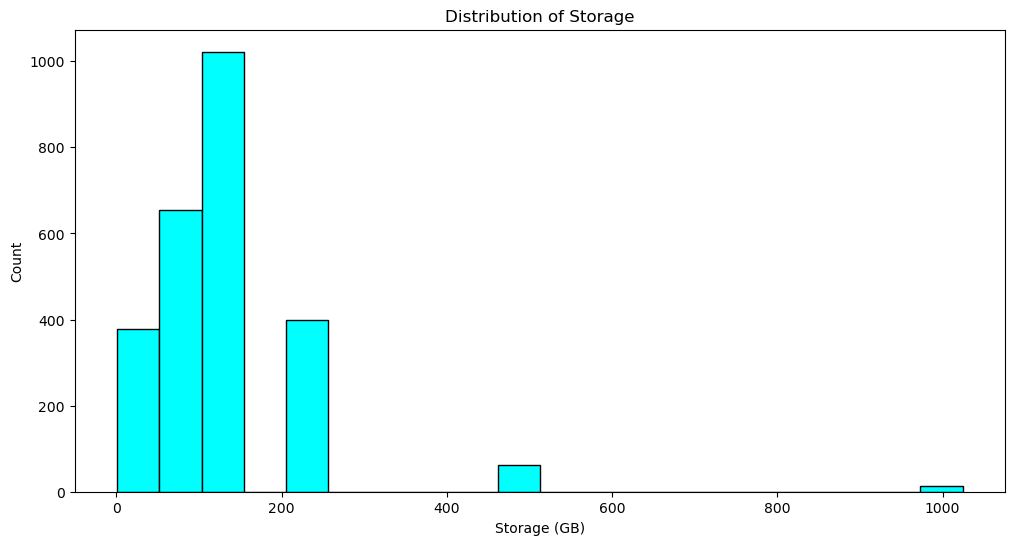

In [72]:
plt.figure(figsize=(12, 6))
plt.hist(mobiles_clean['storage'], bins=20, edgecolor='black', color='#00FFFF')
plt.title('Distribution of Storage')
plt.xlabel('Storage (GB)')
plt.ylabel('Count')
plt.show()

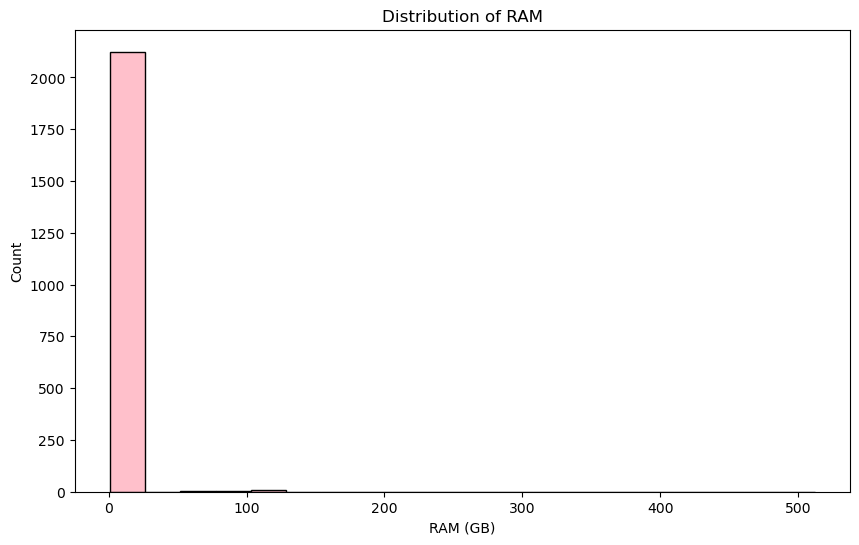

In [73]:
plt.figure(figsize=(10, 6))
plt.hist(mobiles_clean['ram'].dropna(), bins=20, edgecolor='black',color='#FFC0CB') 
plt.title('Distribution of RAM')
plt.xlabel('RAM (GB)')
plt.ylabel('Count')
plt.show()

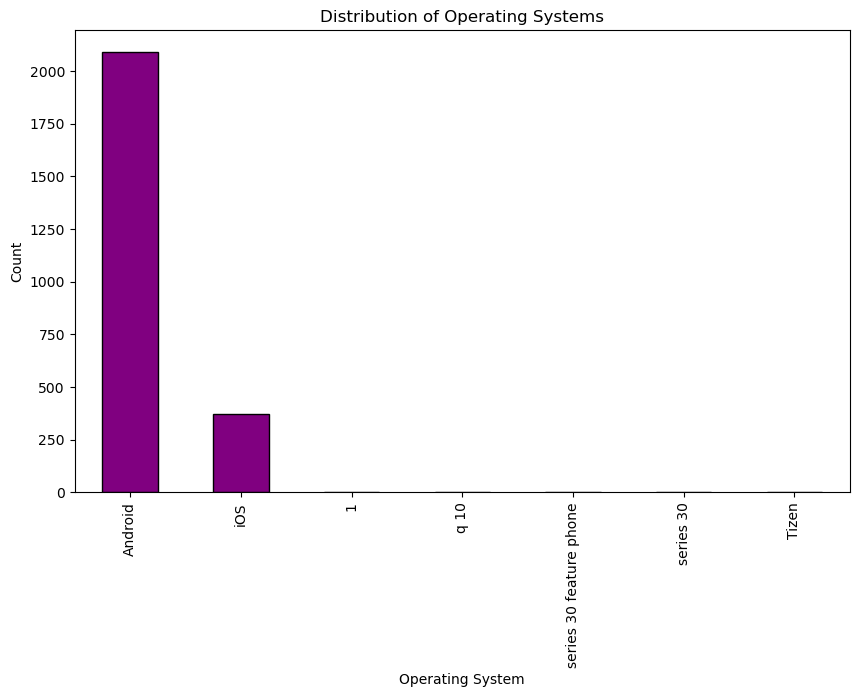

In [74]:
plt.figure(figsize=(10, 6))
mobiles_clean['system'].value_counts().plot(kind='bar',edgecolor='black',color='#800080')
plt.title('Distribution of Operating Systems')
plt.xlabel('Operating System')
plt.ylabel('Count')
plt.show()

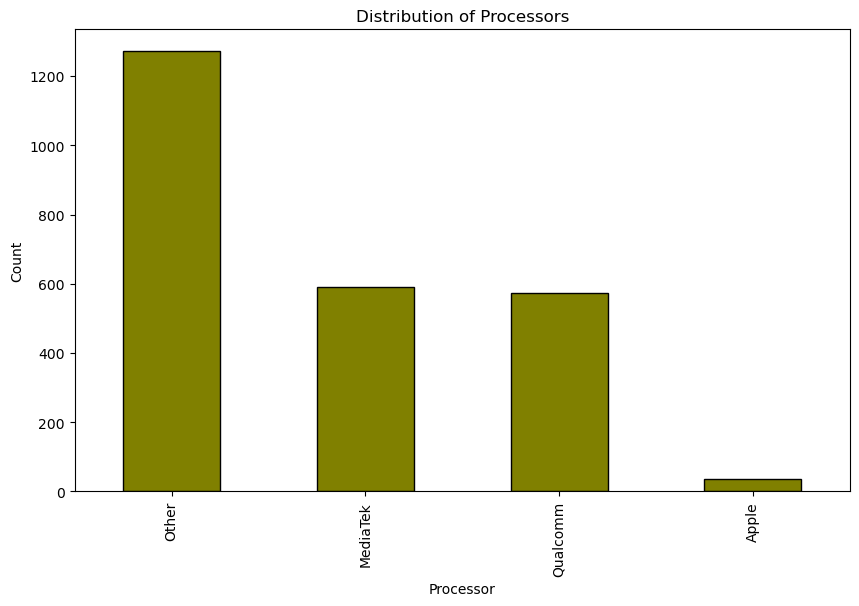

In [75]:
plt.figure(figsize=(10, 6))
mobiles_clean['processor'].value_counts().plot(kind='bar',edgecolor='black',color='#808000')
plt.title('Distribution of Processors')
plt.xlabel('Processor')
plt.ylabel('Count')
plt.show()

In [76]:
def clean_price(price):
    if isinstance(price, (int, float)):  # If the price is already numeric
        return int(price)
    if isinstance(price, str):  # If the price is a string
        cleaned_price = re.sub(r'[^\d]', '', price)  # Remove all non-numeric characters
        if cleaned_price:
            return int(cleaned_price)
    return None 

In [77]:
mobiles_clean.loc[:,'price'] = mobiles_clean['price'].apply(clean_price)

In [78]:
mobiles_clean.head()

,name,ratings,price,imgURL,corpus,storage,ram,system,processor
0,"REDMI Note 12 Pro 5G (Onyx Black, 128 GB)",4.2,23999,https://rukminim2.flixcart.com/image/312/312/x...,storage128 gbram6 systemandroid 12processor t...,128.0,6.0,Android,MediaTek
1,"OPPO F11 Pro (Aurora Green, 128 GB)",4.5,20999,https://rukminim2.flixcart.com/image/312/312/k...,storage128 gbram6 gbexpandable storage256gb s...,128.0,6.0,Android,MediaTek
2,"REDMI Note 11 (Starburst White, 64 GB)",4.2,13149,https://rukminim2.flixcart.com/image/312/312/x...,storage64 gbram4 systemandroid 11processor sp...,64.0,4.0,Android,Other
3,"OnePlus Nord CE 5G (Blue Void, 256 GB)",4.1,21999,https://rukminim2.flixcart.com/image/312/312/x...,storage256 gbram12 systemandroid q 11processo...,256.0,12.0,Android,Qualcomm
4,"APPLE iPhone 13 mini (Blue, 128 GB)",4.6,3537,https://rukminim2.flixcart.com/image/312/312/k...,storage128 systemios 15processor typea15 bion...,128.0,NaN,iOS,Other


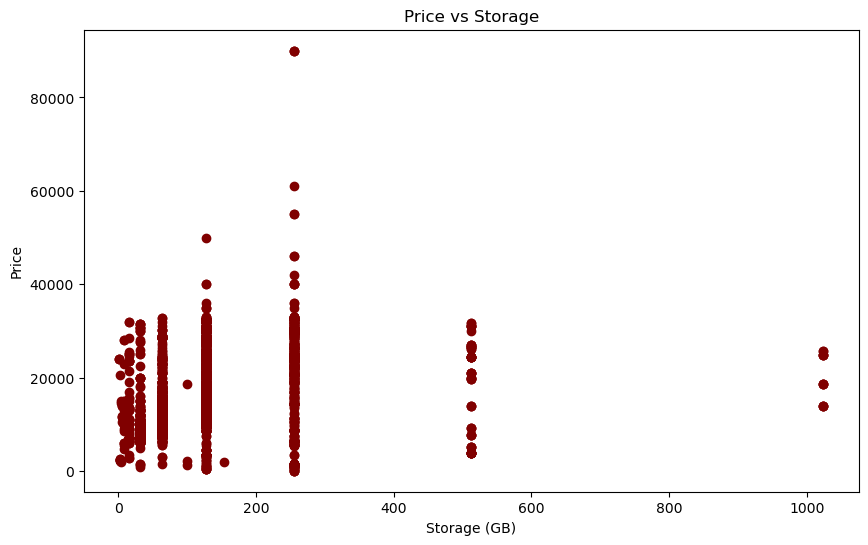

In [79]:
plt.figure(figsize=(10, 6))
plt.scatter(mobiles_clean['storage'], mobiles_clean['price'], color='#800000')
plt.title('Price vs Storage')
plt.xlabel('Storage (GB)')
plt.ylabel('Price')
plt.show()

In [80]:
correlation = mobiles_clean['price'].corr(mobiles_clean['storage'])

correlation

0.27088522618019156

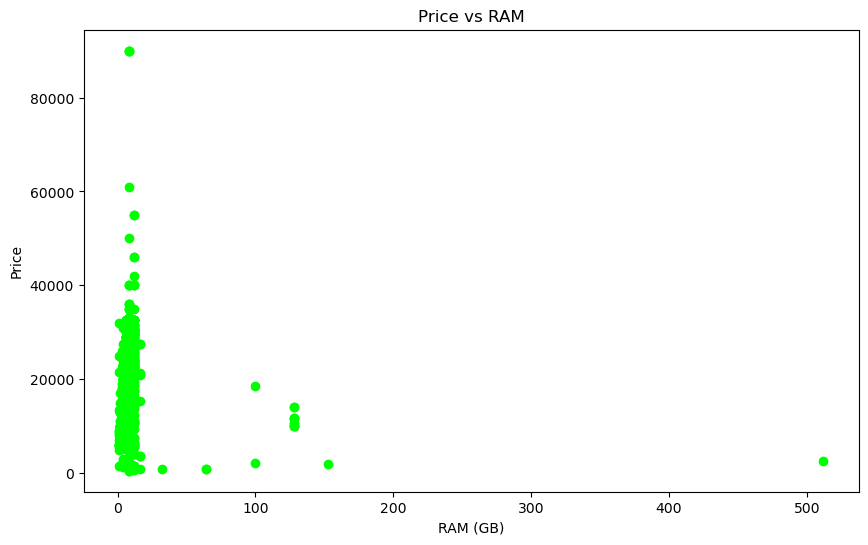

In [81]:
plt.figure(figsize=(10, 6))
plt.scatter(mobiles_clean['ram'], mobiles_clean['price'], color='#00FF00')
plt.title('Price vs RAM')
plt.xlabel('RAM (GB)')
plt.ylabel('Price')
plt.show()

In [82]:
correlation = mobiles_clean['price'].corr(mobiles_clean['ram'])

correlation

0.029167178591028305

In [83]:
avg_price_system = mobiles_clean.groupby('system')['price'].mean()

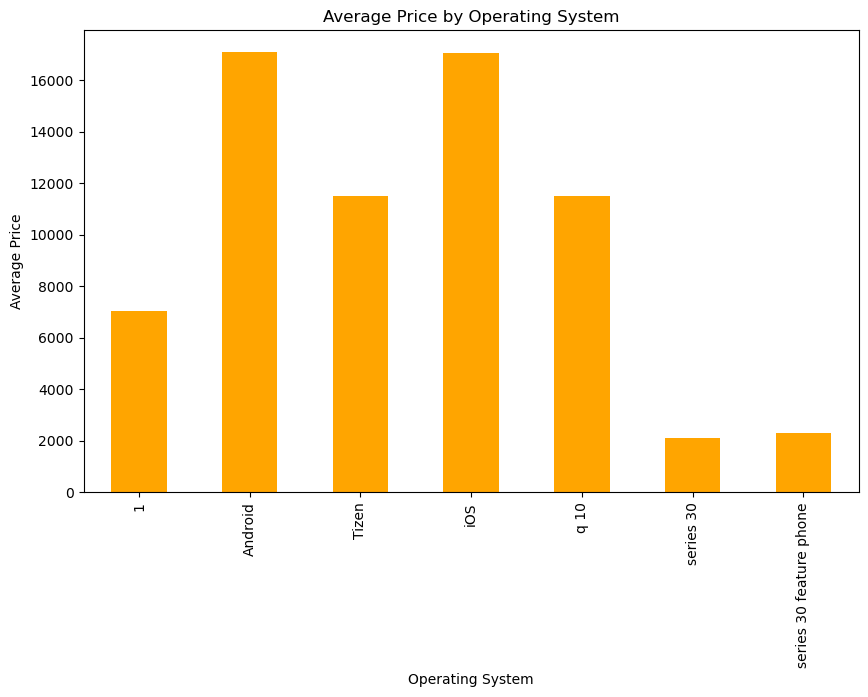

In [84]:
plt.figure(figsize=(10, 6))
avg_price_system.plot(kind='bar',color='#FFA500')
plt.title('Average Price by Operating System')
plt.xlabel('Operating System')
plt.ylabel('Average Price')
plt.show()

In [85]:
avg_price_processor = mobiles_clean.groupby('processor')['price'].mean()

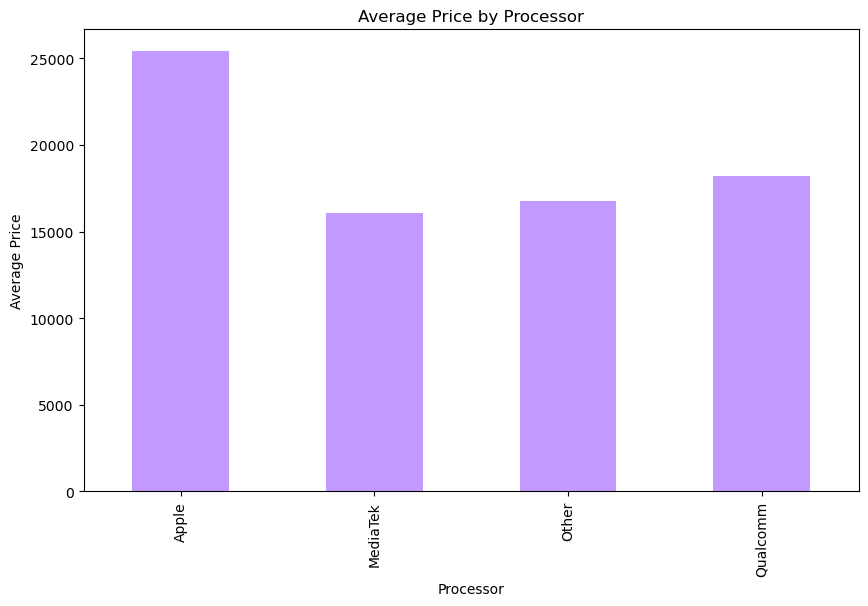

In [86]:
plt.figure(figsize=(10, 6))
avg_price_processor.plot(kind='bar',color='#C299FF')
plt.title('Average Price by Processor')
plt.xlabel('Processor')
plt.ylabel('Average Price')
plt.show()

In [88]:
plt.figure(figsize=(10, 6))
plt.scatter(mobiles_clean['Storage'], mobiles_clean['ratings'], color='#B4EEB4')
plt.title('Ratings vs Storage')
plt.xlabel('Storage (GB)')
plt.ylabel('Ratings')
plt.show()

KeyError: 'Storage'

<Figure size 1000x600 with 0 Axes>

In [ ]:
correlation = mobiles_clean['ratings'].corr(mobiles_clean['storage'])

correlation

In [ ]:
plt.figure(figsize=(10, 6))
plt.scatter(mobiles_clean['ram'], mobiles_clean['ratings'], color='#420079')
plt.title('Ratings vs RAM')
plt.xlabel('RAM (GB)')
plt.ylabel('Ratings')
plt.show()

In [ ]:
correlation = mobiles_clean['ratings'].corr(mobiles_clean['ram'])

correlation

In [ ]:
avg_rating_system = mobiles_clean.groupby('system')['ratings'].mean()

In [ ]:
plt.figure(figsize=(10, 6))
avg_rating_system.plot(kind='bar', color='#F4CCCC')
plt.title('Average Rating by Operating System')
plt.xlabel('Operating System')
plt.ylabel('Average Rating')
plt.show()

In [ ]:
avg_rating_processor = mobiles_clean.groupby('processor')['ratings'].mean()

In [ ]:
plt.figure(figsize=(10, 6))
avg_rating_processor.plot(kind='bar', color='#FF00FF')
plt.title('Average Rating by Processor')
plt.xlabel('Processor')
plt.ylabel('Average Rating')
plt.show()

In [ ]:
def extract_brand(name):
    return name.split()[0]

In [ ]:
mobiles_clean.loc[:,'brand'] = mobiles_clean['name'].apply(extract_brand)

In [ ]:
mobiles_clean.head()

In [ ]:
plt.figure(figsize=(10, 6))
mobiles_clean['brand'].value_counts().plot(kind='bar',color='#ff9999')
plt.title('Distribution of Brands')
plt.xlabel('Brand')
plt.ylabel('Count')
plt.show()

In [ ]:
avg_price_brand = mobiles_clean.groupby('brand')['price'].mean()

In [ ]:
plt.figure(figsize=(10, 6))
avg_price_brand.plot(kind='bar',color='#ff0080')
plt.title('Average Price by Brand')
plt.xlabel('Brand')
plt.ylabel('Average Price')
plt.show()

In [ ]:
avg_rating_brand = mobiles_clean.groupby('brand')['ratings'].mean()

In [ ]:
plt.figure(figsize=(10, 6))
avg_rating_brand.plot(kind='bar' ,color='#bf00ff')
plt.title('Average Rating by Brand')
plt.xlabel('Brand')
plt.ylabel('Average Rating')
plt.show()

In [ ]:
mobiles_clean.columns

In [ ]:
numeric_features = ['storage', 'ram', 'price','ratings']
categorical_features = ['system', 'processor', 'brand']

In [ ]:
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())])

In [ ]:
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
   ('onehot', OneHotEncoder(handle_unknown='ignore'))])

In [ ]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])

In [ ]:
max_len = 0
for i in range(0, len(mobiles_clean['corpus'])):
    try:
        if len(mobiles_clean['corpus'][i]) > max_len:
            max_len = len(mobiles_clean['corpus'][i])
    except:
        pass

print(f'words max len in corpus is: {max_len}')

In [ ]:
#convert text to matrix
from sklearn.feature_extraction.text import CountVectorizer  

In [ ]:
corpus = mobiles_clean['corpus'].astype(str).tolist() 

In [ ]:
#limit the number of words to consider
cont_vect = CountVectorizer(max_features=1000)

In [ ]:
X = cont_vect.fit_transform(corpus)
vectors = X.toarray()

In [ ]:
feature_names=cont_vect.get_feature_names_out()

In [ ]:
feature_names

In [ ]:
#from vectors matrix shape
similarity = cosine_similarity(vectors)
similarity.shape

In [ ]:
#cosine similarity between the 4th row and all other rows, including itself
similarity[3]

In [ ]:
#sorts the similarity scores of the 1st row with respect to all other rows, excluding the row itself
#retrieves the top 10 most similar rows
sorted(list(enumerate(similarity[0])),reverse=True,key=lambda x:x[1])[1:11]

In [ ]:
def recommend(mobile):
    #find the index of the given mobile
    mobile_index = mobiles_clean[mobiles_clean['name']==mobile].index[0]
    #retrieve similarity scores
    similarity_array = similarity[mobile_index]
    #find top 10 similar mobiles
    similar_10_mobiles = sorted(list(enumerate(similarity_array)),reverse=True,key=lambda x:x[1])[1:11]
    
    for i in similar_10_mobiles:
        print(mobiles_clean['name'].iloc[i[0]])

In [ ]:
recommend('APPLE iPhone 13 mini (Blue, 128 GB)')

In [ ]:
def random_values(df:mobiles_clean,col_name:str,total=9):
    if col_name not in mobiles_clean.columns:
        raise ValueError(f"Column '{col_name}' does not exist in the DataFrame.")
    
    if mobiles_clean.empty:
        raise ValueError("The DataFrame is empty.")
        
    for i in range(0,total):
        index = np.random.randint(mobiles_clean.shape[0])
        print(index,':',mobiles_clean[col_name].iloc[index])  

In [ ]:
random_values(mobiles_clean,'corpus')

In [ ]:
#create directories recursively
os.makedirs(r'src\model',exist_ok=True)

In [ ]:
#save the dataframe toa file
pickle.dump(obj=mobiles_clean,file=open(file=r'src\model\dataframe.pkl',mode='wb'))

In [ ]:
pickle.dump(obj=similarity,file=open(file=r'src\model\similarity.pkl',mode='wb'))

In [ ]:
mobiles_clean.to_csv('mobile_processed_data.csv', index=False)